In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
from langchain.prompts import ChatPromptTemplate


import re

from dotenv import load_dotenv

load_dotenv()

True

In [2]:
llm = ChatGroq(
    model="llama3-8b-8192",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

### BASIC CHATBOT

In [100]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

memory = MemorySaver()

In [101]:
def chatbot(state: State):
    return {'messages': [llm.invoke(state['messages'])]}

In [102]:
graph_builder = StateGraph(State)

graph_builder.add_node('chatbot', chatbot)

graph_builder.add_edge(START, 'chatbot')
graph_builder.add_edge('chatbot', END)

# graph = graph_builder.compile(checkpointer=memory)
graph = graph_builder.compile()

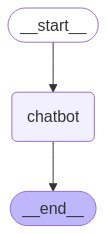

In [103]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [104]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="What happened in the Olympics")

graph.invoke({'messages' : [input_message]}, config)

{'messages': [HumanMessage(content='What happened in the Olympics', additional_kwargs={}, response_metadata={}, id='afd1a856-d420-491c-8ccb-52614fc6e66b'),
  AIMessage(content="You're referring to the most recent Olympic Games! The 2020 Summer Olympics, officially known as the Games of the XXXII Olympiad, took place in Tokyo, Japan, from July 23 to August 8, 2021. Here are some of the highlights:\n\n**Medal Count:**\n\n* United States: 39 gold medals, 41 silver medals, 33 bronze medals (total: 113 medals)\n* China: 38 gold medals, 32 silver medals, 18 bronze medals (total: 88 medals)\n* Japan: 27 gold medals, 14 silver medals, 17 bronze medals (total: 58 medals)\n\n**Notable Moments:**\n\n1. **Simone Biles withdraws:** American gymnast Simone Biles withdrew from the team final and the individual all-around competition due to a mental health issue, sparking a global conversation about athlete well-being.\n2. **Neeraj Chopra's historic gold:** Indian athlete Neeraj Chopra won the country

### WITH TOOLS

In [ ]:
memory = MemorySaver()

market_analysis_prompt_template = ChatPromptTemplate.from_messages([
    ('user', '''
                Given that the stock prices for the past twenty days are: {stock_prices}, and the time-series forecast for the next 7 days
                are {predicted_prices}, provide a comprehensive market analysis of the stock.
            ''')
])

follow_up_prompt_template = ChatPromptTemplate.from_messages([
    ('user', '''
                 You an assistant that responds to follow up questions based on chat history
     
                 This is the chat history with the user: {chat_history}\n
     
                This user has a follow up question: {query}
            ''')
])

class State(TypedDict):
    messages: Annotated[list, add_messages]
    stock_prices: list
    predicted_prices: list
    end_chat: bool
    follow_up: str

def stock_prices(state: State):
    """fetches stock prices"""

    return """
        1. 2025-03-26: $2,444.99
        2. 2025-03-25: $2,434.99
        3. 2025-03-24: $2,424.99
        4. 2025-03-23: $2,414.99
        5. 2025-03-22: $2,404.99
        6. 2025-03-21: $2,394.99
        7. 2025-03-20: $2,384.99
        8. 2025-03-19: $2,374.99
        9. 2025-03-18: $2,364.99
        10. 2025-03-17: $2,354.99
        11. 2025-03-16: $2,344.99
        12. 2025-03-15: $2,334.99
        13. 2025-03-14: $2,324.99
        14. 2025-03-13: $2,314.99
        15. 2025-03-12: $2,304.99
        16. 2025-03-11: $2,294.99
        17. 2025-03-10: $2,284.99
        18. 2025-03-09: $2,274.99
        19. 2025-03-08: $2,264.99
        20. 2025-03-07: $2,254.99
        21. 2025-03-06: $2,244.99
        22. 2025-03-05: $2,234.99
        23. 2025-03-04: $2,224.99
        24. 2025-03-03: $2,214.99
        25. 2025-03-02: $2,204.99
        26. 2025-02-28: $2,194.99
        27. 2025-02-27: $2,184.99
        28. 2025-02-26: $2,174.99
        29. 2025-02-25: $2,164.99
        30. 2025-02-24: $2,154.99
        """

def stock_forecaster(state: State):
    pattern = r"(\d{4}-\d{2}-\d{2}): \$?([\d,]+\.\d{2})"

    matches = re.findall(pattern, state['messages'][2].content)

    structured_prices = [{"date": date, "price": float(price.replace(",", ""))} for date, price in matches]

    return {'stock_prices': structured_prices, 'predicted_prices': ['1,834', '1,734', '1,934', '1,724', '1,254', '1,834', '1,734']}

def market_analyser(state: State):
    analyst = market_analysis_prompt_template | llm

    response = analyst.invoke({
        'stock_prices': state['stock_prices'], 
        'predicted_prices': state['predicted_prices']
    })

    return {'messages': [response], 'analysis': response.content}

def follow_up_chatbot(state: State):
    follow_up = follow_up_prompt_template | llm

    response = follow_up.invoke({
        'chat_history': state['messages'], 
        'query': state['follow_up']
    })

    return {'messages': [response], 'end_chat': True}

tools = [stock_prices]
llm_with_tools = llm.bind_tools(tools=tools)

def route_logic(state: State):
    """Route logic to determine the next node."""
    display(f"Route logic {state}.")  # Debugging
    if state.get('end_chat') == True:
        display("Chat is ending.")  # Debugging
        return END
    elif state.get('follow_up'):
        display("follow up")  # Debugging
        return 'follow_up_chatbot'
    else:
        display("tools")  # Debugging
        return 'tools'

def chatbot(state: State):
    response = llm_with_tools.invoke(state['messages'])
    return {'messages': [response]}

graph_builder = StateGraph(State)

graph_builder.add_node('chatbot', chatbot)
graph_builder.add_node('stock_forecaster', stock_forecaster)
graph_builder.add_node('market_analyser', market_analyser)
graph_builder.add_node('follow_up_chatbot', follow_up_chatbot)

tool_node = ToolNode(tools=tools)

graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", route_logic, {"tools": "tools", "follow_up_chatbot": "follow_up_chatbot", END: END})
# graph_builder.add_conditional_edges("chatbot", END)

graph_builder.add_edge('tools', 'stock_forecaster')
graph_builder.add_edge('stock_forecaster', 'market_analyser')
graph_builder.add_edge('follow_up_chatbot', 'chatbot')

graph_builder.add_edge('market_analyser', END)
graph_builder.set_entry_point('chatbot')

graph = graph_builder.compile(checkpointer=memory)


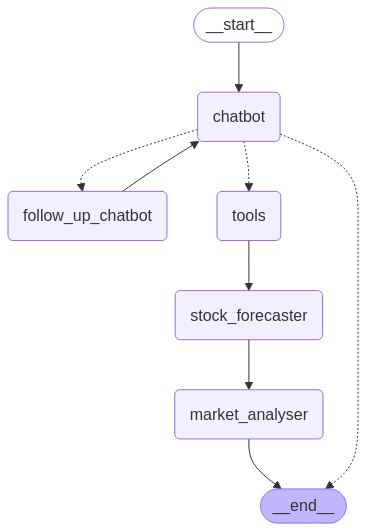

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    display('e no work')
    pass

In [25]:
from datetime import datetime

config = {"configurable": {"thread_id": "1"}}
stock = 'GOOG'
# Get today's date
today = datetime.today().date()

today = today.strftime("%Y-%m-%d")

# user_input = HumanMessage(content=f"Market analysis of GOOG stock prices")

# events = graph.stream(
#     {"messages": [user_input]},
#     config,
#     stream_mode="values",
# )

# for event in events:
#     event["messages"][-1].pretty_print()

In [26]:
user_input = HumanMessage(content=f"Market analysis of GOOG stock prices over the past 20 days alongside possible forecast, today's date is {today}, e.g 1. 2025-02-26: $2312.12")

state = graph.invoke({'messages' : [user_input]}, config)

'Route logic {\'messages\': [HumanMessage(content="Market analysis of GOOG stock prices over the past 20 days alongside possible forecast, today\'s date is 2025-03-27, e.g 1. 2025-02-26: $2312.12", additional_kwargs={}, response_metadata={}, id=\'4072812c-3b04-4249-85b9-f13424f94384\'), AIMessage(content=\'\', additional_kwargs={\'tool_calls\': [{\'id\': \'call_29mc\', \'function\': {\'arguments\': \'{"state":{"end_chat":true,"follow_up":"GOOG","messages":[],"predicted_prices":[],"stock_prices":[{"date":"2025-03-07","price":"2345.67"},{"date":"2025-03-08","price":"2351.23"},{"date":"2025-03-09","price":"2356.78"},{"date":"2025-03-10","price":"2362.34"},{"date":"2025-03-11","price":"2368.91"},{"date":"2025-03-12","price":"2375.48"},{"date":"2025-03-13","price":"2382.05"},{"date":"2025-03-14","price":"2388.62"},{"date":"2025-03-15","price":"2395.19"},{"date":"2025-03-16","price":"2401.76"},{"date":"2025-03-17","price":"2408.33"},{"date":"2025-03-18","price":"2414.90"},{"date":"2025-03-19

'tools'

In [27]:
state

{'messages': [HumanMessage(content="Market analysis of GOOG stock prices over the past 20 days alongside possible forecast, today's date is 2025-03-27, e.g 1. 2025-02-26: $2312.12", additional_kwargs={}, response_metadata={}, id='4072812c-3b04-4249-85b9-f13424f94384'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_29mc', 'function': {'arguments': '{"state":{"end_chat":true,"follow_up":"GOOG","messages":[],"predicted_prices":[],"stock_prices":[{"date":"2025-03-07","price":"2345.67"},{"date":"2025-03-08","price":"2351.23"},{"date":"2025-03-09","price":"2356.78"},{"date":"2025-03-10","price":"2362.34"},{"date":"2025-03-11","price":"2368.91"},{"date":"2025-03-12","price":"2375.48"},{"date":"2025-03-13","price":"2382.05"},{"date":"2025-03-14","price":"2388.62"},{"date":"2025-03-15","price":"2395.19"},{"date":"2025-03-16","price":"2401.76"},{"date":"2025-03-17","price":"2408.33"},{"date":"2025-03-18","price":"2414.90"},{"date":"2025-03-19","price":"2421.47"},{"date":

In [28]:
print(state['messages'][-1].content)

**Market Analysis**

**Historical Data Analysis**

The historical stock price data for the past 20 days shows a downward trend, with a slight increase in the last few days. The stock price has been steadily decreasing from $2444.99 to $2194.99, with a total decline of 10.5% over the 20-day period.

**Key Statistics**

* Highest price: $2444.99 (2025-03-26)
* Lowest price: $2194.99 (2025-02-28)
* Average price: $2314.99
* Standard deviation: $54.99
* Variance: 3.02%

**Time-Series Forecast Analysis**

The time-series forecast for the next 7 days shows a mixed trend, with prices ranging from $1254 to $1934. The forecast suggests that the stock price may continue to fluctuate in the short-term, with no clear direction.

**Comparison of Historical and Forecast Data**

The historical data shows a downward trend, while the forecast data suggests a mixed trend. This could indicate that the stock price may be due for a rebound or a correction in the short-term.

**Market Sentiment Analysis**



In [29]:
query='what stock are we talking about'
user_input = HumanMessage(content=query)
next_state = graph.invoke({'messages' : [user_input], 'follow_up': query, 'end_chat': False}, config= config)

# events = graph.stream(
#     {"messages": [user_input], 'follow_up': query, 'end_chat': False},
#     config,
#     stream_mode="values",
# )

# for event in events:
#     event["messages"][-1].pretty_print()

'Route logic {\'messages\': [HumanMessage(content="Market analysis of GOOG stock prices over the past 20 days alongside possible forecast, today\'s date is 2025-03-27, e.g 1. 2025-02-26: $2312.12", additional_kwargs={}, response_metadata={}, id=\'4072812c-3b04-4249-85b9-f13424f94384\'), AIMessage(content=\'\', additional_kwargs={\'tool_calls\': [{\'id\': \'call_29mc\', \'function\': {\'arguments\': \'{"state":{"end_chat":true,"follow_up":"GOOG","messages":[],"predicted_prices":[],"stock_prices":[{"date":"2025-03-07","price":"2345.67"},{"date":"2025-03-08","price":"2351.23"},{"date":"2025-03-09","price":"2356.78"},{"date":"2025-03-10","price":"2362.34"},{"date":"2025-03-11","price":"2368.91"},{"date":"2025-03-12","price":"2375.48"},{"date":"2025-03-13","price":"2382.05"},{"date":"2025-03-14","price":"2388.62"},{"date":"2025-03-15","price":"2395.19"},{"date":"2025-03-16","price":"2401.76"},{"date":"2025-03-17","price":"2408.33"},{"date":"2025-03-18","price":"2414.90"},{"date":"2025-03-19

'follow up'

'Route logic {\'messages\': [HumanMessage(content="Market analysis of GOOG stock prices over the past 20 days alongside possible forecast, today\'s date is 2025-03-27, e.g 1. 2025-02-26: $2312.12", additional_kwargs={}, response_metadata={}, id=\'4072812c-3b04-4249-85b9-f13424f94384\'), AIMessage(content=\'\', additional_kwargs={\'tool_calls\': [{\'id\': \'call_29mc\', \'function\': {\'arguments\': \'{"state":{"end_chat":true,"follow_up":"GOOG","messages":[],"predicted_prices":[],"stock_prices":[{"date":"2025-03-07","price":"2345.67"},{"date":"2025-03-08","price":"2351.23"},{"date":"2025-03-09","price":"2356.78"},{"date":"2025-03-10","price":"2362.34"},{"date":"2025-03-11","price":"2368.91"},{"date":"2025-03-12","price":"2375.48"},{"date":"2025-03-13","price":"2382.05"},{"date":"2025-03-14","price":"2388.62"},{"date":"2025-03-15","price":"2395.19"},{"date":"2025-03-16","price":"2401.76"},{"date":"2025-03-17","price":"2408.33"},{"date":"2025-03-18","price":"2414.90"},{"date":"2025-03-19

'Chat is ending.'

In [30]:
display(next_state)

{'messages': [HumanMessage(content="Market analysis of GOOG stock prices over the past 20 days alongside possible forecast, today's date is 2025-03-27, e.g 1. 2025-02-26: $2312.12", additional_kwargs={}, response_metadata={}, id='4072812c-3b04-4249-85b9-f13424f94384'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_29mc', 'function': {'arguments': '{"state":{"end_chat":true,"follow_up":"GOOG","messages":[],"predicted_prices":[],"stock_prices":[{"date":"2025-03-07","price":"2345.67"},{"date":"2025-03-08","price":"2351.23"},{"date":"2025-03-09","price":"2356.78"},{"date":"2025-03-10","price":"2362.34"},{"date":"2025-03-11","price":"2368.91"},{"date":"2025-03-12","price":"2375.48"},{"date":"2025-03-13","price":"2382.05"},{"date":"2025-03-14","price":"2388.62"},{"date":"2025-03-15","price":"2395.19"},{"date":"2025-03-16","price":"2401.76"},{"date":"2025-03-17","price":"2408.33"},{"date":"2025-03-18","price":"2414.90"},{"date":"2025-03-19","price":"2421.47"},{"date":

In [31]:
query='how are you'
user_input = HumanMessage(content=query)
next_state = graph.invoke({'messages' : [user_input], 'follow_up': query, 'end_chat': False}, config= config)


'Route logic {\'messages\': [HumanMessage(content="Market analysis of GOOG stock prices over the past 20 days alongside possible forecast, today\'s date is 2025-03-27, e.g 1. 2025-02-26: $2312.12", additional_kwargs={}, response_metadata={}, id=\'4072812c-3b04-4249-85b9-f13424f94384\'), AIMessage(content=\'\', additional_kwargs={\'tool_calls\': [{\'id\': \'call_29mc\', \'function\': {\'arguments\': \'{"state":{"end_chat":true,"follow_up":"GOOG","messages":[],"predicted_prices":[],"stock_prices":[{"date":"2025-03-07","price":"2345.67"},{"date":"2025-03-08","price":"2351.23"},{"date":"2025-03-09","price":"2356.78"},{"date":"2025-03-10","price":"2362.34"},{"date":"2025-03-11","price":"2368.91"},{"date":"2025-03-12","price":"2375.48"},{"date":"2025-03-13","price":"2382.05"},{"date":"2025-03-14","price":"2388.62"},{"date":"2025-03-15","price":"2395.19"},{"date":"2025-03-16","price":"2401.76"},{"date":"2025-03-17","price":"2408.33"},{"date":"2025-03-18","price":"2414.90"},{"date":"2025-03-19

'follow up'

'Route logic {\'messages\': [HumanMessage(content="Market analysis of GOOG stock prices over the past 20 days alongside possible forecast, today\'s date is 2025-03-27, e.g 1. 2025-02-26: $2312.12", additional_kwargs={}, response_metadata={}, id=\'4072812c-3b04-4249-85b9-f13424f94384\'), AIMessage(content=\'\', additional_kwargs={\'tool_calls\': [{\'id\': \'call_29mc\', \'function\': {\'arguments\': \'{"state":{"end_chat":true,"follow_up":"GOOG","messages":[],"predicted_prices":[],"stock_prices":[{"date":"2025-03-07","price":"2345.67"},{"date":"2025-03-08","price":"2351.23"},{"date":"2025-03-09","price":"2356.78"},{"date":"2025-03-10","price":"2362.34"},{"date":"2025-03-11","price":"2368.91"},{"date":"2025-03-12","price":"2375.48"},{"date":"2025-03-13","price":"2382.05"},{"date":"2025-03-14","price":"2388.62"},{"date":"2025-03-15","price":"2395.19"},{"date":"2025-03-16","price":"2401.76"},{"date":"2025-03-17","price":"2408.33"},{"date":"2025-03-18","price":"2414.90"},{"date":"2025-03-19

'Chat is ending.'

In [32]:
display(next_state)

{'messages': [HumanMessage(content="Market analysis of GOOG stock prices over the past 20 days alongside possible forecast, today's date is 2025-03-27, e.g 1. 2025-02-26: $2312.12", additional_kwargs={}, response_metadata={}, id='4072812c-3b04-4249-85b9-f13424f94384'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_29mc', 'function': {'arguments': '{"state":{"end_chat":true,"follow_up":"GOOG","messages":[],"predicted_prices":[],"stock_prices":[{"date":"2025-03-07","price":"2345.67"},{"date":"2025-03-08","price":"2351.23"},{"date":"2025-03-09","price":"2356.78"},{"date":"2025-03-10","price":"2362.34"},{"date":"2025-03-11","price":"2368.91"},{"date":"2025-03-12","price":"2375.48"},{"date":"2025-03-13","price":"2382.05"},{"date":"2025-03-14","price":"2388.62"},{"date":"2025-03-15","price":"2395.19"},{"date":"2025-03-16","price":"2401.76"},{"date":"2025-03-17","price":"2408.33"},{"date":"2025-03-18","price":"2414.90"},{"date":"2025-03-19","price":"2421.47"},{"date":